This task uses GREG Bigbin as database.
At first, we still need to start neo4j/GREG, if you don't know how to do it, please refer to [my workshop2 about graph Algorithms](https://nbviewer.jupyter.org/github/xiaowei3223/GREGgraphAlgorithms/blob/master/workshop2/GREG_Algorithms.ipynb) to learn for start neo4j/GREG.

[1. Number of nodes of each type (TF, chr1, etc)](#1)

[2. Number of relationships of each type (bind, etc)](#2)

[3. List of hubs for chr12 (a hub is a node with a high degree)](#3)

[4. Degree distribution for chr12 (GREG-min)](#4)

[Degree of TF](#11)

[5. Modules for chromosome 12](#5)

[6. Annotate all modules with the genes they contain in their bins](#6)

[6.1  learn how to get the genes ](#6.1)

[6.2  Get genes in each modules ](#6.2)

[6.3  enriched modules in some KEGG pathway or GO term.](#6.3)

[ 6.3.1 Enrich GO ](#6.3.1)

[ 6.3.2 Enrich KEGG](#6.3.2)

[7. Get All genes names](#7)

[ 8. Find the modules that contain the gene "NANOG" and report all the nodes and relationships inside such modules. Also, report if they are enriched in some KEGG pathway or GO term . ](#8)

[ Step1： Find out those nodes about target genes](#8.1)

[ Step2: To get modules which includes target genes](#8.2)

[ Step3: build a function to get relationships during nodes in each community(module)](#8.3)

[ step4: get relationships during nodes in each community(module)](#8.4)

[9. Select the modules that include NANOG AND CTCF AND EP300 AND POLR2A AND YY1 AND cohesin (RAD21, SMC3, OR STAG1) AND mediator (MED1 or MED12).](#9)

[ Step1: Get nodes in all gene names in chromosomes,TF and LncRNA.](#9.1)

[ Step2: A vector about out genes.](#9.2)

[ Step3: Create a function `geneMatchIndex` for find out those nodes that genes we want.](#9.3)

[ Step4: Find out those nodes that genes we want.](#9.4)

[ Step5: To get modules which includes target genes](#9.5)

[ Step6: Build a function to judge which modules is we want.](#9.6)

[ Step7: Select those mudules as we want](#9.7)

[ Step8: get relationships during nodes in each community(module)](#9.8)

[10  save all results](#10)

Now, we use `RNeo4j` package to get all the results of the task.

In [1]:
#connect neo4j with RNeo4j
library(RNeo4j)

graph = startGraph("http://localhost:7474/db/data/", username="neo4j", password="xiaowei")

In [2]:
#---define the backgroup of plot
library(ggplot2)
backgroup <-   theme(axis.text.x = element_text(vjust = 0.5, hjust = 1, angle = 90 ),
                     plot.title = element_text(face ="bold" ,hjust = 0.5),
                     panel.grid.major = element_blank(), #删除网格线
                     panel.grid.minor = element_blank(), #删除网格线
                     panel.background=element_rect(fill='transparent',color ="gray"))

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windowsRegistered S3 method overwritten by 'grid':
  method     from  
  print.path RNeo4j


<h1 id='1'>1. Number of nodes of each type (TF, chr1, etc)<h1>

Number of the allnode is 1267023.

In [3]:
cypher(graph, query ="MATCH (n) RETURN count(n) as AllNodes" )

AllNodes
<int>
1267023


In [4]:
query = "MATCH (n) RETURN distinct labels(n) as label, count(labels(n)) as count"

labels <- cypher(graph,query) 

In [5]:
labels

label,count
<chr>,<int>
chr1,1245
chr2,1211
chr3,992
chr4,951
chr5,908
chr6,854
chr7,797
chr8,726
chr9,692


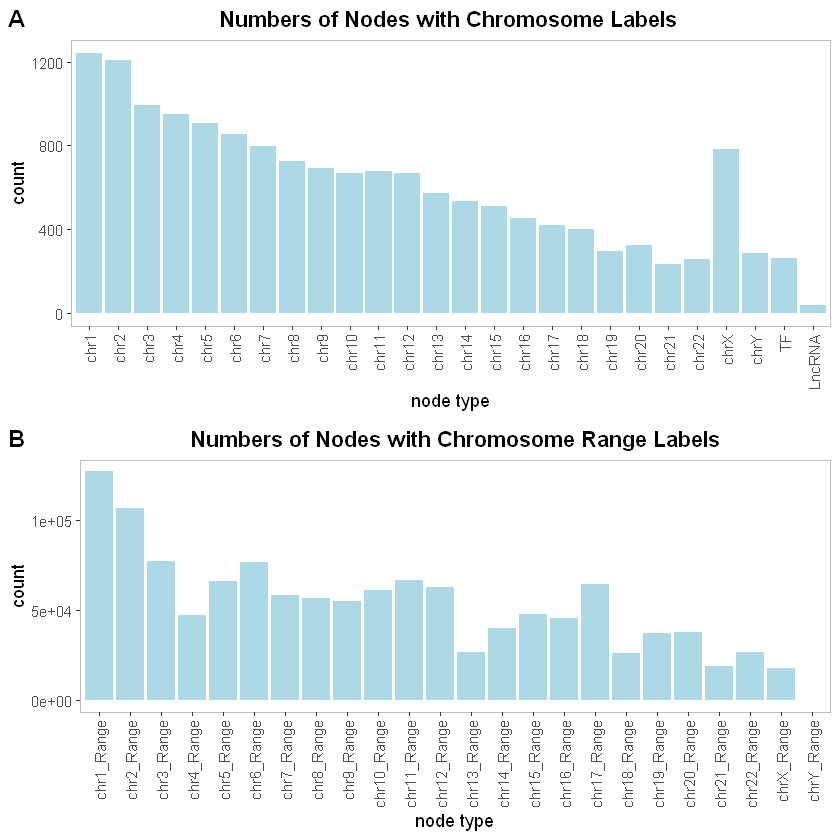

In [6]:
labels$label <- factor(labels$label，levels = c(labels$label))
par(mfrow=c(1,2))

p = function(data){
  library(ggplot2)
  ggplot() + 
    geom_bar(aes(x = data$label, y = data$count),
             stat="identity", fill = "lightblue")+ 
    labs(x="node type",y = "count")+ backgroup
}
par(mfrow=c(1,2))
p1 <- p(labels[c(1:25,50),]) + ggtitle("Numbers of Nodes with Chromosome Labels ")
p2 <- p(labels[26:49,]) + ggtitle("Numbers of Nodes with Chromosome Range Labels")

cowplot::plot_grid(p1, p2, labels = c("A", "B"), ncol = 1)

In [7]:
query = "MATCH (n) return count(n) as ALLNODES"
cypher(graph, query)

ALLNODES
<int>
1267023


In [8]:
write.csv(labels, file = "labels.csv", sep=",",quote = F, col.names = TRUE, row.names = FALSE)

Warning message in write.csv(labels, file = "labels.csv", sep = ",", quote = F, :
"attempt to set 'col.names' ignored"Warning message in write.csv(labels, file = "labels.csv", sep = ",", quote = F, :
"attempt to set 'sep' ignored"

To get `labels.csv` at [here](labels.csv).

<h1 id='2'>2. Number of relationships of each type (bind, etc)<h1>

To get numbers of relationships of each type.

In [9]:
query = "MATCH ()-[r]->() RETURN type(r) as relationshipType, count(*) as count;"

relationshipType <- RNeo4j::cypher(graph,query)

In [10]:
relationshipType

relationshipType,count
<chr>,<int>
Bind,2372086
Interaction,1781980
Inclusion,1322494


To get numbers of relationships between two kinds of labels.

In [11]:
query <- "MATCH (A)-[r]->(B) 
return labels(A) AS A, 
        type(r) AS relationshipType, 
        labels(B) AS B ,
        count(r) AS count"
rel_details <- cypher(graph, query)

In [12]:
head(rel_details)

A,relationshipType,B,count
<chr>,<chr>,<chr>,<int>
chr1,Inclusion,chr1_Range,134855
chr2,Inclusion,chr2_Range,114769
chr3,Inclusion,chr3_Range,81332
chr4,Inclusion,chr4_Range,49491
chr5,Inclusion,chr5_Range,69435
chr6,Inclusion,chr6_Range,80840


In [13]:

BindRel <- rel_details[which(rel_details$relationshipType == "Bind"), ] 

#-----TF Binding relationship-----
BindRel_TF <- BindRel[which(BindRel$A == "TF"),]
BindRel_TFSUM <- sum(BindRel_TF$count)

#-------LncRNA Bind relationship---------------
BindRel_LncRNA <- BindRel[which(BindRel$A == "LncRNA"),]
BindRel_LncRNASUM <- sum(BindRel_LncRNA$count)

#-----Interaction relationship --------------
InteractionRel <- rel_details[rel_details$relationshipType =="Interaction",]

#---------TF - TF interaction relationships-------------
TFInteractionRel <- InteractionRel[InteractionRel$A == "TF",]
TFInteractionRelSUM <- sum(TFInteractionRel$count)

#--------chr_Range - chr_Range raltionships-------------
chr_RangeRel <- InteractionRel[InteractionRel$A != "TF",]
chr_RangeRelSUM <- sum(chr_RangeRel$count)


In [14]:
relationship_Type = c('TF binding ', 'lncRNA binding',
                     'TF-TF interactions', 'DNA-DNA interactions')
SumCount = c(BindRel_TFSUM,BindRel_LncRNASUM ,TFInteractionRelSUM, chr_RangeRelSUM)
RelSUM = data.frame(relationship_Type, SumCount)


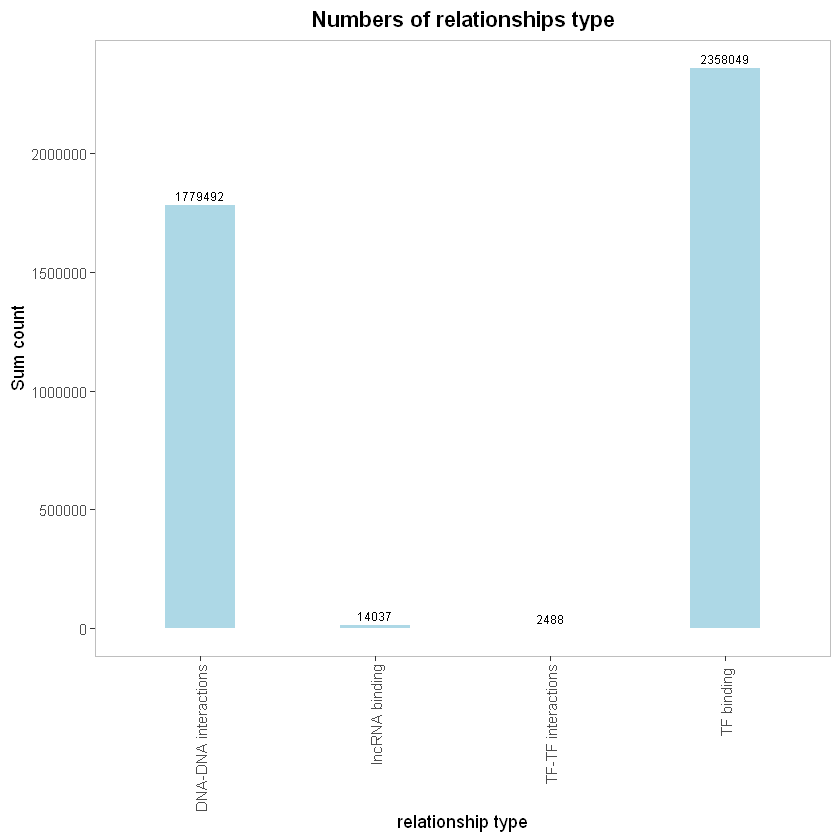

In [15]:
ggplot() + 
      geom_bar(aes(x = RelSUM$relationship_Type, y = RelSUM$SumCount),
               stat="identity", fill = "lightblue", width = 0.4,position=position_dodge(0.01))+ 
      labs(x="relationship type",y = "Sum count")+
      ggtitle("Numbers of relationships type") + backgroup+
geom_text(aes(x = RelSUM$relationship_Type, y = RelSUM$SumCount, label=RelSUM$SumCount), size = 2.5,hjust= 0.5, vjust = -0.5 )

To see Bind relatioships

In [16]:
#-------TF Bind chromosome---------------
library(ggplot2)
chr_level = c(paste0("chr",1:22),"chrX", "chrY")
BindRel <- rel_details[which(rel_details$relationshipType == "Bind"), ] 
BindRel_TF <- BindRel[which(BindRel$A == "TF"),]
BindRel_TF$B <- factor(BindRel_TF$B, levels = chr_level)

In [17]:
p3 <- ggplot() + 
      geom_bar(aes(x = BindRel_TF$B, y = BindRel_TF$count),
               stat="identity", fill = "lightblue")+ 
      labs(x="label",y = "count")+
      ggtitle("TF Bind Chromosome") + backgroup

In [18]:
#-------LncRNA Bind chromosome---------------
BindRel_LncRNA <- BindRel[which(BindRel$A == "LncRNA"),]
BindRel_LncRNA$B <- factor(BindRel_LncRNA$B, levels = chr_level)

p4 <- ggplot() + 
      geom_bar(aes(x = BindRel_LncRNA$B, y = BindRel_LncRNA$count),
               stat="identity", fill = "lightblue")+ 
      labs(x="label",y = "count")+
      ggtitle("LncRNA Bind Chromosome") + backgroup


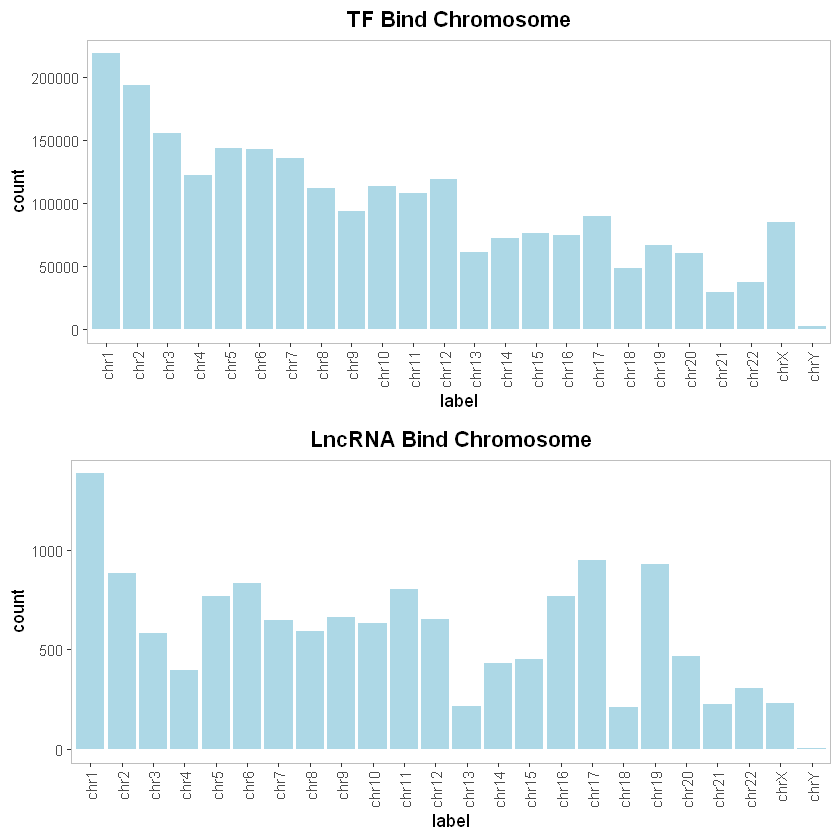

In [19]:
#-------grouping plots-------------
par(mfrow=c(1,2))
cowplot::plot_grid(p3, p4, ncol = 1)

To see the Inclusion relationships

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

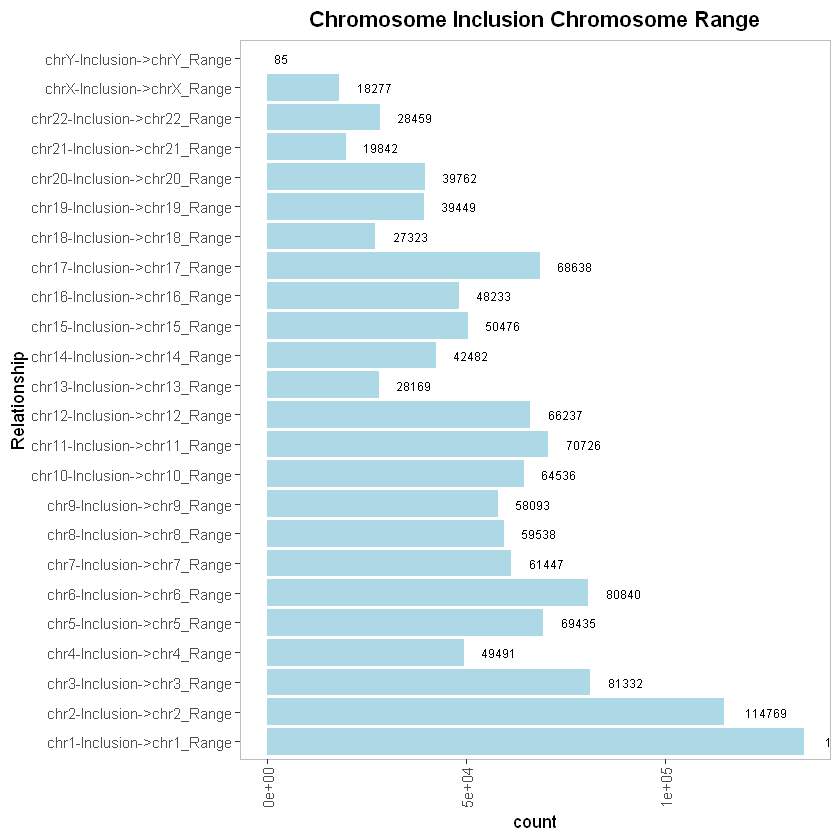

In [20]:
#--------chr inclusion chr_Range----------------------------
InclusionRel <- rel_details[rel_details$relationshipType =="Inclusion",]

InclusionRel$rel <- apply(InclusionRel[1:3], 1， FUN = function(X){ y = paste0(X[1],"-",X[2],"->",X[3]) })
chrRange_level <- c(paste0("chr",1:22,"-Inclusion->chr",1:22,"_Range"),
                    "chrX-Inclusion->chrX_Range",
                    "chrY-Inclusion->chrY_Range")
InclusionRel$rel <- factor(InclusionRel$rel, levels = chrRange_level)

ggplot() + 
  geom_bar(aes(x = InclusionRel$rel, y = InclusionRel$count),
           stat="identity", fill = "lightblue")+ 
  labs(x="Relationship",y = "count")+
  ggtitle("Chromosome Inclusion Chromosome Range") + backgroup +  #设置背景为白色
  coord_flip()+ #将条形图坐标轴转换过来变成横向条形图
geom_text(aes(x = InclusionRel$rel, y = InclusionRel$count, label=InclusionRel$count), size = 2.5,hjust=-0.5 )


To see the Interaction relationships

I don't how to create a picture for the Interaction relationships, so I show you its data.

In [21]:
InteractionRel <- rel_details[rel_details$relationshipType =="Interaction",]
#InteractionRel

<h1 id='3'>3. List of hubs for chr12 (a hub is a node with a high degree)<h1>

chr12 nodes have Bind and Interaction relationships. 

At the first, we use cypher command `'MATCH (allnodes) return allnodes'` for the first argument of `algo.degree.stream`; then we will difine whole graph with all relationships during all nodes.

After using degree algorithm, we need to filter all chr12 nodes by `MATCH (chr12:chr12)
where id(chr12) = nodeId and score > 50` and to remove those 0 degree score of chr12. 

At the end, we return back chr12 nodes names and its degree score. 

In [22]:
query = "
CALL algo.degree.stream(
                        'MATCH (allnodes) return allnodes',
                        'Interaction | Inclution | Bind',
                        {direction: 'both'})
YIELD nodeId, score
with nodeId, score
MATCH (chr12:chr12)
where id(chr12) = nodeId and score > 50
RETURN chr12.Name AS Name, score as degree
ORDER By score DESC
"
chr12_hubs <- cypher(graph, query)

In [23]:
head(chr12_hubs)

Name,degree
<chr>,<dbl>
Bin247,673
Bin281,661
Bin272,625
Bin267,600
Bin35,588
Bin246,572


In [24]:
dim(chr12_hubs)

[1] 626   2

In [25]:
write.table(chr12_hubs, file = "chr12_hubs.csv",sep=",",quote = F, col.names = TRUE, row.names = FALSE)

To get chr12_hubs.csv at [here](chr12_hubs.csv)

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

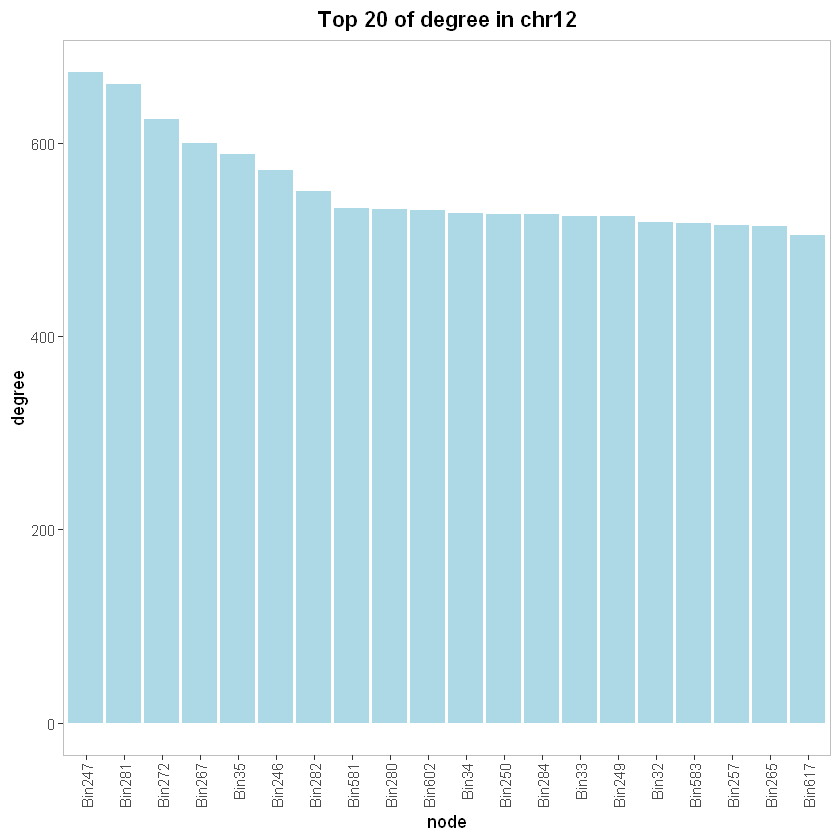

In [26]:
chr12_hubs_20 <- chr12_hubs[1:20,]
chr12_hubs_20$Name <- factor(chr12_hubs_20$Name, levels = chr12_hubs_20$Name)
ggplot() + 
    geom_bar(aes(x = chr12_hubs_20$Name, y = chr12_hubs_20$degree),
           stat="identity", fill = "lightblue")+ 
  labs(x="node",y = "degree")+
  ggtitle("Top 20 of degree in chr12") + backgroup   #设置背景为白色

<h1 id='4'>4. Degree distribution for chr12 <h1>

In [27]:
chr12_distribution <- as.data.frame(table(chr12_hubs$degree))
library(ggplot2)
#ggplot(chr12_distribution, aes(x=Freq))+ geom_histogram(binwidth=.5)

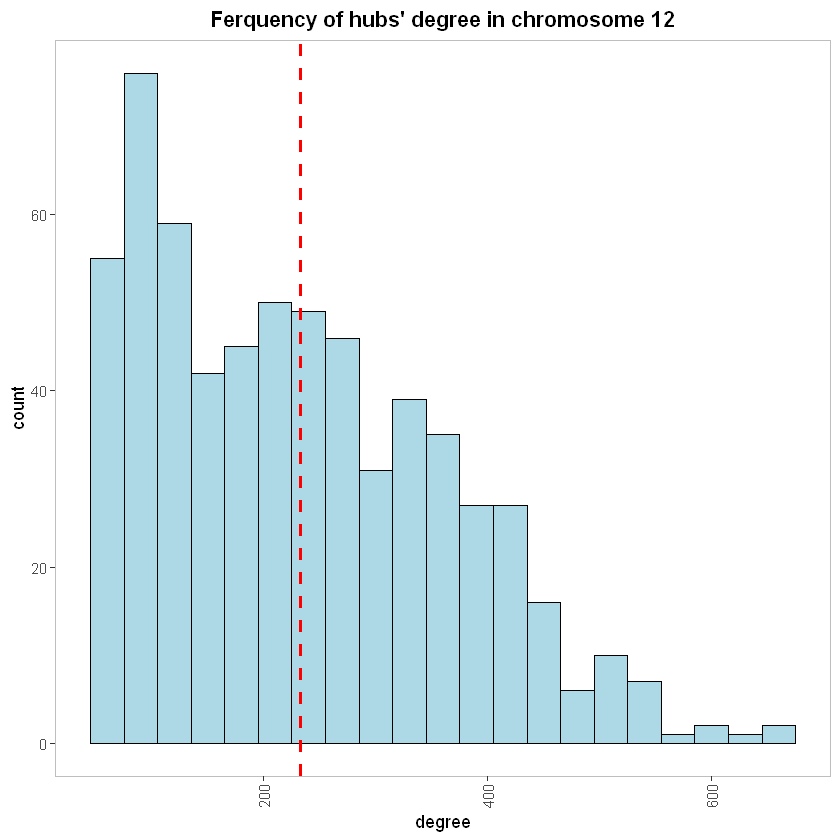

In [28]:
ggplot(chr12_hubs, aes(x=degree))+ 
  geom_histogram(binwidth=30,colour="black", fill = "lightblue")+ #distribution plot
  geom_vline(aes(xintercept=mean(degree, na.rm=T)), color="red", linetype="dashed", size=1)+   #mean
  ggtitle("Ferquency of hubs' degree in chromosome 12") + backgroup

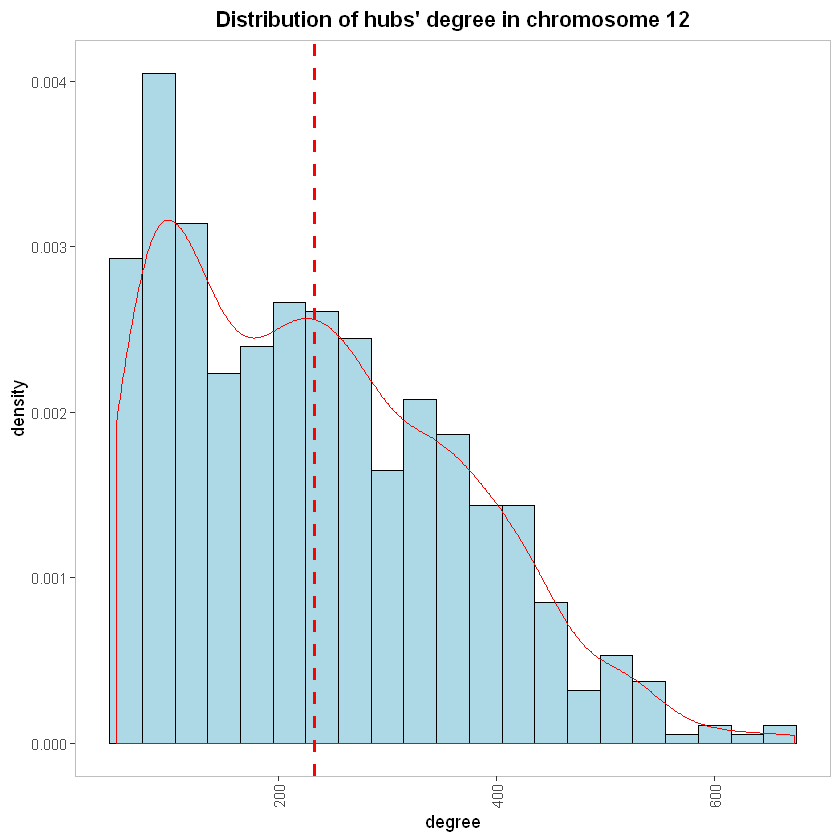

In [29]:
ggplot(chr12_hubs, aes(x=degree)) + 
  geom_histogram(aes(y=..density..),binwidth=30,colour="black", fill = "lightblue")+ #distribution plot
  geom_density(alpha=.2, color="red")+  #density line,Smoothed density estimates
  geom_vline(aes(xintercept=mean(degree, na.rm=T)), color="red", linetype="dashed", size=1)+  #mean
  ggtitle("Distribution of hubs' degree in chromosome 12")+ backgroup

In [30]:
chr12_distribution[chr12_distribution$Freq ==max(chr12_distribution$Freq),]

,Var1,Freq
,<fct>,<int>
27,79,8


<h1 id = '11'>Degree of TF <h1>

In [31]:
query = "
CALL algo.degree.stream(
                        'MATCH (allnodes) return allnodes',
                        'Interaction | Inclution | Bind',
                        {direction: 'both'})
YIELD nodeId, score
with nodeId, score
MATCH (TF:TF)
where id(TF) = nodeId and score > 50
RETURN TF.Name AS Name, score as degree
ORDER By score DESC
"
TF_hubs <- cypher(graph, query)

In [32]:
head(TF_hubs)

Name,degree
<chr>,<dbl>
ESR1,14480
CTCF,14367
POLR2A,14338
MYC,14329
CEBPB,14316
LMNB1,14271


Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

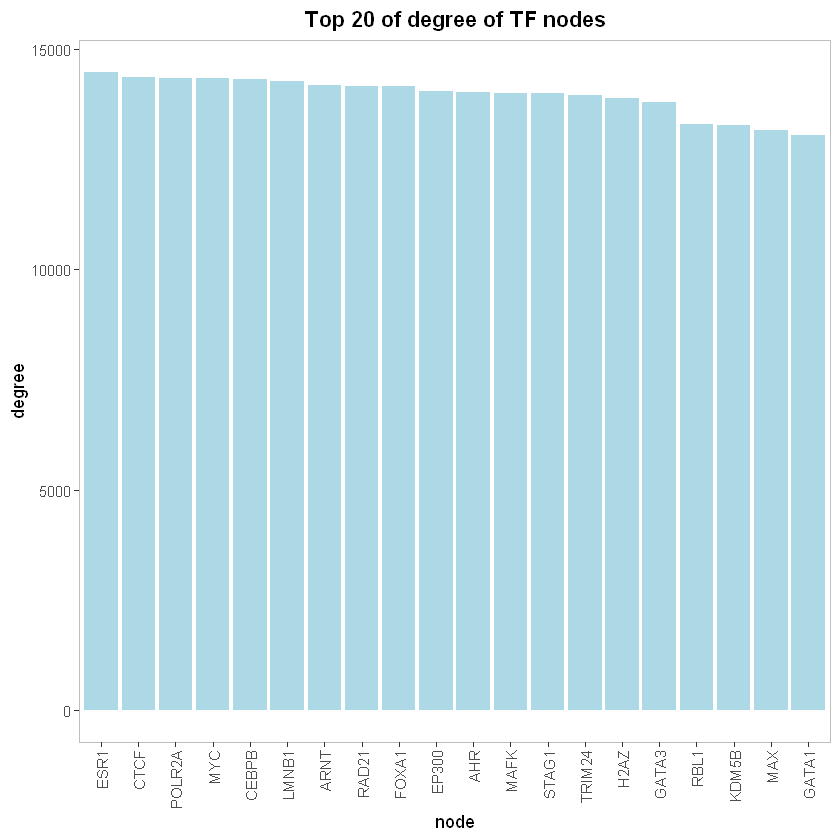

In [33]:
TF_hubs_20 <- TF_hubs[1:20,]
TF_hubs_20$Name <- factor(TF_hubs_20$Name, levels = TF_hubs_20$Name)
ggplot() + 
  geom_bar(aes(x = TF_hubs_20$Name, y = TF_hubs_20$degree),
           stat="identity", fill = "lightblue")+ 
  labs(x="node",y = "degree")+
  ggtitle("Top 20 of degree of TF nodes") + backgroup   #设置背景为白色

In [34]:
dim(TF_hubs)

[1] 240   2

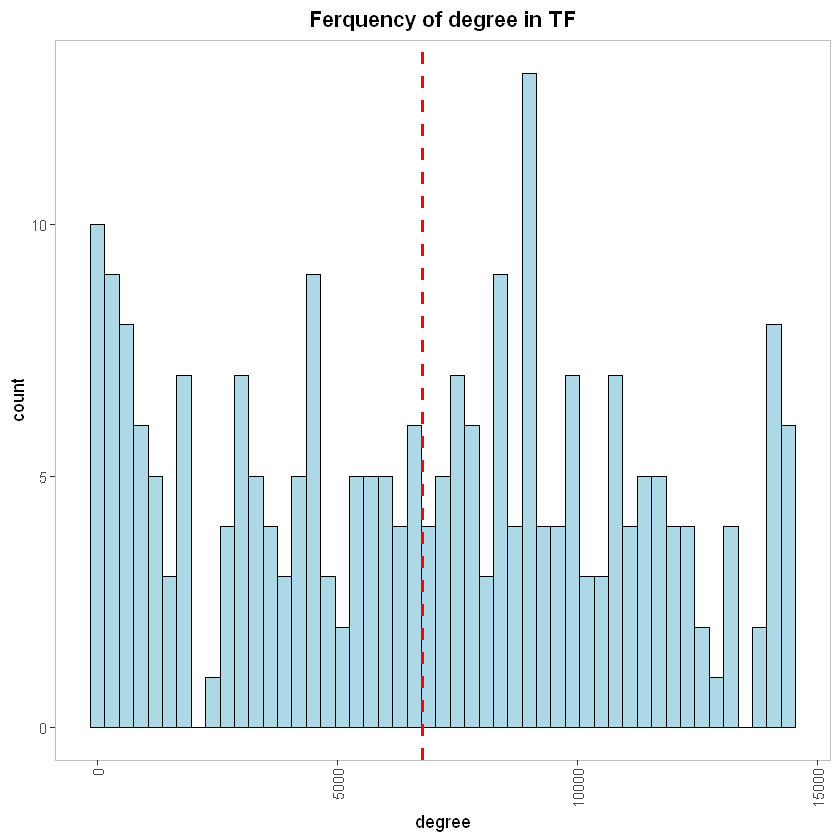

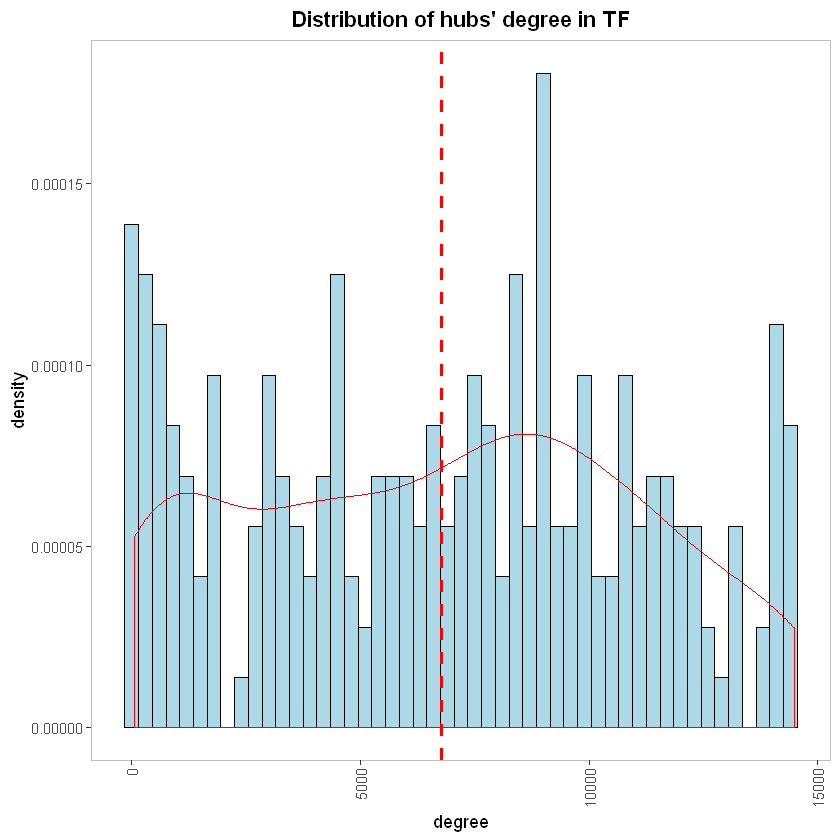

In [35]:
TF_distribution <- as.data.frame(table(TF_hubs$degree))
library(ggplot2)
#ggplot(distribution, aes(x=Freq))+ geom_histogram(binwidth=.5)

ggplot(TF_hubs, aes(x=degree))+ 
  geom_histogram(binwidth=300,colour="black", fill = "lightblue")+ #distribution plot
  geom_vline(aes(xintercept=mean(degree, na.rm=T)), color="red", linetype="dashed", size=1)+   #mean
  ggtitle("Ferquency of degree in TF") + backgroup

ggplot(TF_hubs, aes(x=degree)) + 
  geom_histogram(aes(y=..density..),binwidth=300,colour="black", fill = "lightblue")+ #distribution plot
  geom_density(alpha=.2, color="red")+  #density line,Smoothed density estimates
  geom_vline(aes(xintercept=mean(degree, na.rm=T)), color="red", linetype="dashed", size=1)+  #mean
  ggtitle("Distribution of hubs' degree in TF")+ backgroup

<h1 id='5'>5. Modules for chromosome 12<h1>

In [36]:
# To know the numbers of modules ----------------
query = "CALL algo.louvain(
                        'MATCH (n:chr12)--(m) with id(n) as chr12,id(m) AS m   MATCH (al) where id(al) = m or  id(al) = chr12 return id(al) as id',
                        'MATCH (n:chr12)-[r]-(m) RETURN id(n) AS source, id(m) AS target',
                        {graph:'cypher',direction: 'both'})
YIELD nodes, communityCount"
cypher(graph, query)  #Results： nodes:370956 communityCount:307385

nodes,communityCount
<int>,<int>
370956,307385


At here analysis, you need to know 1288086 nodes including all chr12 nodes and all nodes directly related chr12 nodes.

##### Then we filter all nodes are chr12 in their community as following:

In [37]:
# To know the numbers of chr12 nodes in each modules ----------------
query = "
// to make louvain modules for chr12
CALL algo.louvain.stream(
  'MATCH (n:chr12)--(m) with id(n) as chr12,id(m) AS m   MATCH (al) where id(al) = m or  id(al) = chr12 return id(al) as id',
  'MATCH (n:chr12)-[r]-(m) RETURN id(n) AS source, id(m) AS target',
  {graph:'cypher',direction: 'both'})
YIELD nodeId, community

// filering community which the number of nodes is more than one
with collect(nodeId) AS nodeId , community
where size(nodeId) > 1
with nodeId, 'Module'+ community as community

// to get communities that contain chromosome 12 nodes. 
MATCH (chr12:chr12)
where id(chr12) in nodeId
with collect( chr12.Name )  AS GeneList, community
RETURN GeneList, community, size(GeneList) AS Size
ORDER BY Size DESC
"
module_chr12_total = cypher(graph, query) 

In [38]:
module_chr12_total[1:2,]

GeneList,community,Size
<list>,<chr>,<int>
"Bin17 , Bin37 , Bin38 , Bin39 , Bin43 , Bin44 , Bin46 , Bin47 , Bin48 , Bin50 , Bin53 , Bin55 , Bin56 , Bin57 , Bin66 , Bin69 , Bin70 , Bin71 , Bin72 , Bin73 , Bin76 , Bin78 , Bin82 , Bin83 , Bin85 , Bin86 , Bin87 , Bin88 , Bin89 , Bin90 , Bin91 , Bin92 , Bin93 , Bin94 , Bin95 , Bin97 , Bin99 , Bin100, Bin101, Bin102, Bin103, Bin104, Bin105, Bin106, Bin107, Bin110, Bin111, Bin112, Bin115, Bin116, Bin117, Bin118, Bin119, Bin120, Bin121, Bin122, Bin123, Bin142, Bin143, Bin144, Bin145, Bin149, Bin150, Bin151, Bin153, Bin166, Bin167, Bin170, Bin174, Bin175, Bin177, Bin178, Bin181, Bin183, Bin185, Bin188, Bin189, Bin190, Bin191, Bin192, Bin193, Bin194, Bin196, Bin197, Bin198, Bin199, Bin200, Bin201, Bin202, Bin203, Bin204, Bin205, Bin206, Bin207, Bin208, Bin209, Bin210, Bin215, Bin216, Bin217, Bin218, Bin221, Bin222, Bin223, Bin224, Bin226, Bin230, Bin234, Bin238, Bin243, Bin255, Bin258, Bin271, Bin274, Bin275, Bin276, Bin277, Bin278, Bin291, Bin292, Bin294, Bin295, Bin297, Bin298, Bin299, Bin300, Bin301, Bin302, Bin303, Bin304, Bin305, Bin306, Bin307, Bin308, Bin309, Bin310, Bin311, Bin316, Bin317, Bin318, Bin320, Bin322, Bin325, Bin326, Bin327, Bin333, Bin334, Bin335, Bin336, Bin340, Bin341, Bin344, Bin345, Bin346, Bin351, Bin353, Bin355, Bin356, Bin357, Bin360, Bin361, Bin362, Bin363, Bin364, Bin365, Bin366, Bin367, Bin368, Bin369, Bin370, Bin371, Bin372, Bin374, Bin375, Bin376, Bin387, Bin388, Bin389, Bin390, Bin391, Bin392, Bin393, Bin394, Bin395, Bin396, Bin397, Bin401, Bin402, Bin403, Bin404, Bin405, Bin406, Bin407, Bin408, Bin409, Bin410, Bin411, Bin413, Bin414, Bin415, Bin416, Bin417, Bin418, Bin419, Bin420, Bin421, Bin422, Bin424, Bin425, Bin426, Bin427, Bin428, Bin429, Bin430, Bin431, Bin432, Bin433, Bin434, Bin435, Bin436, Bin437, Bin438, Bin439, Bin440, Bin442, Bin443, Bin445, Bin450, Bin451, Bin452, Bin453, Bin454, Bin455, Bin457, Bin460, Bin472, Bin473, Bin474, Bin484, Bin485, Bin486, Bin487, Bin488, Bin489, Bin490, Bin491, Bin492, Bin495, Bin496, Bin497, Bin498, Bin499, Bin500, Bin504, Bin505, Bin506, Bin511, Bin512, Bin514, Bin515, Bin516, Bin517, Bin518, Bin533, Bin541, Bin543, Bin564, Bin575, Bin576, Bin577, Bin583, Bin584, Bin588, Bin594, Bin595, Bin597, Bin622, Bin627, Bin628, Bin629, Bin630, Bin631, Bin632, Bin633, Bin634, Bin635, Bin636, Bin637, Bin638, Bin639, Bin640, Bin641, Bin643, Bin646, Bin648, Bin649, Bin650, Bin651, Bin652, Bin653, Bin656",Module11194,301
"Bin15 , Bin20 , Bin22 , Bin24 , Bin41 , Bin42 , Bin52 , Bin74 , Bin98 , Bin108, Bin109, Bin114, Bin125, Bin126, Bin135, Bin136, Bin154, Bin156, Bin158, Bin160, Bin161, Bin164, Bin165, Bin171, Bin172, Bin179, Bin195, Bin212, Bin225, Bin229, Bin312, Bin313, Bin319, Bin339, Bin347, Bin354, Bin359, Bin373, Bin384, Bin386, Bin412, Bin441, Bin459, Bin475, Bin503, Bin507, Bin508, Bin534, Bin540, Bin545, Bin555, Bin557, Bin565, Bin570, Bin586, Bin591, Bin599, Bin626, Bin645, Bin654, Bin655, Bin657, Bin658, Bin659",Module10134,64


In [39]:
dim(module_chr12_total)

[1] 50  3

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

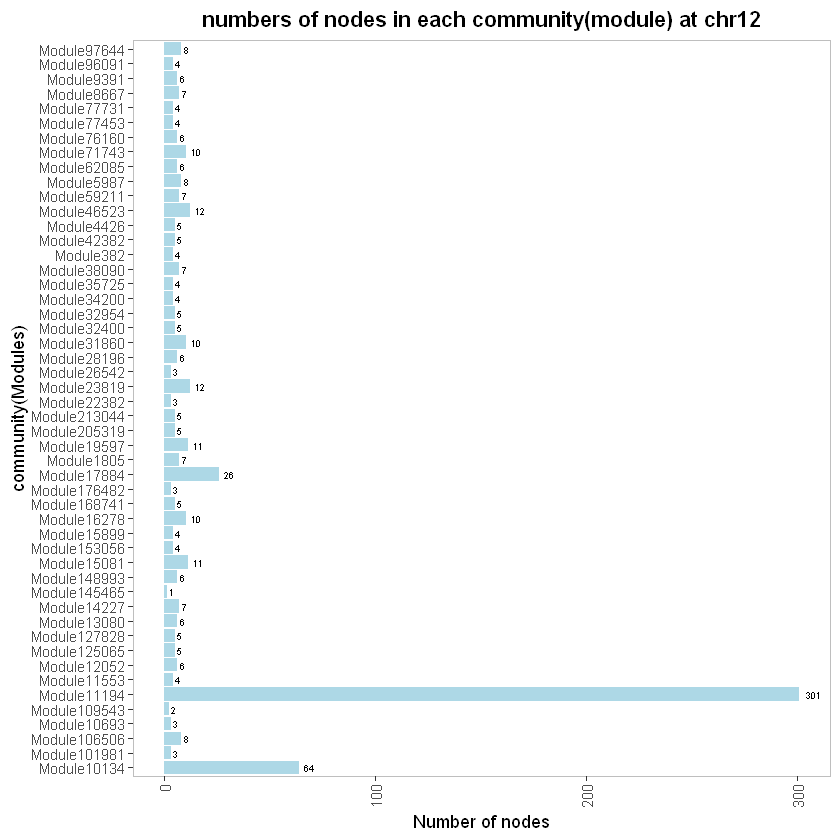

In [40]:
ggplot() + 
  geom_bar(aes(x = module_chr12_total$community, y = module_chr12_total$Size),
           stat="identity", fill = "lightblue")+ 
  labs(x="community(Modules)",y = "Number of nodes")+
  ggtitle("numbers of nodes in each community(module) at chr12") + backgroup+
  geom_text(aes(x = module_chr12_total$community, 
                y = module_chr12_total$Size,
                label=module_chr12_total$Size), hjust=-0.5, size = 2)+
  coord_flip() #将条形图坐标轴转换过来变成横向条形图

<h1 id='6'>6. Annotate all modules with the genes they contain in their bins<h1>

<h2 id='6.1'> learn how to get the genes </h2>

Before we run to get genes, we should learn string function `split()` and `substring()`.

Example is a chr12 node, we use `split()` to get a list of details property of this node.   

`split()` returns a list of strings resulting from the splitting of the original string around matches of the given delimiter.

Syntax: `split(original, splitDelimiter)`

In [41]:
query = "MATCH( chr12:chr12{Name: 'Bin20'})
RETURN split(chr12.Details, ';') as Details"
cypher(graph,query)

Details
<list>
"3791047 , 3873448 , gene_id ENSG00000111224.13 , gene_type protein_coding , gene_name PARP11 , level 2 , havana_gene OTTHUMG00000156442.5, |3839459 , 3842525 , gene_id ENSG00000118976.5 , gene_type processed_pseudogene , gene_name HIN1L , level 1 , tag pseudo_consens , havana_gene OTTHUMG00000168119.1, |3871734 , 3910338 , gene_id ENSG00000256862.1 , gene_type antisense , gene_name RP11-664D1.1 , level 2 , havana_gene OTTHUMG00000168120.1,"


In order to you can easy to see that this result is list; we use `UNWIND` to  transform this list back into individual rows.

In [42]:
query = "MATCH( chr12:chr12{Name: 'Bin20'})
with split(chr12.Details, ';') as Details
UNWIND Details AS details
RETURN details
"
cypher(graph,query)

details
<chr>
3791047
3873448
gene_id ENSG00000111224.13
gene_type protein_coding
gene_name PARP11
level 2
havana_gene OTTHUMG00000156442.5
|3839459
3842525


Now, we use `substring()` to get gene names. In Details property, gene names always use `gene_name ` for tell use what its genes contained in this nodes.

`substring()` returns a substring of the original string, beginning with a 0-based index start and length.

Syntax: `substring(original, start [, length])`

In [43]:
query = "MATCH( chr12:chr12{Name: 'Bin20'})
with split(chr12.Details, ';') as Details
UNWIND Details AS details
with details as details
where details contains 'gene_name'
with details as genes
return substring(genes,11) as genes
"
cypher(graph,query)

genes
<chr>
PARP11
HIN1L
RP11-664D1.1


<h2 id='6.2'> Get genes in each modules </h2>

So, the node chr12 `Bin200` includes 3 genes.

###### Now, we can use that functions to do our tasks.

In [44]:
query = "
// to make louvain modules for chr12
CALL algo.louvain.stream(
  'MATCH (n:chr12)--(m) with id(n) as chr12,id(m) AS m   MATCH (al) where id(al) = m or  id(al) = chr12 return id(al) as id',
  'MATCH (n:chr12)-[r]-(m) RETURN id(n) AS source, id(m) AS target',
  {graph:'cypher',direction: 'both'})
YIELD nodeId, community

// filering community which the number of nodes is more than one
with collect(nodeId) AS nodeId , community
where size(nodeId) > 1
with nodeId, 'Module'+ community AS community

// to get communities that contain chromosome 12 nodes. 
MATCH (chr12:chr12)
where id(chr12) in nodeId

// split details
with split(chr12.Details, ';') as ann, community

// then ann is list, we need unlist ann for strings search
UNWIND (ann) as ann1
with  ann1 as ann1, community

// now we want to find out which one terms including gene_name in ann1
where ann1 contains 'gene_name'
with ann1 as genelist, community

// And we can extract the text about real gene names
return distinct substring(genelist, 11) as genelist, community
"

module_chr12 = cypher(graph, query) 

In [45]:
head(module_chr12)

genelist,community
<chr>,<chr>
DDX11L8,Module382
ABC7-42389800N19.1,Module382
RP11-598F7.1,Module382
IQSEC3,Module382
RP11-598F7.3,Module382
RP11-598F7.4,Module382


In [46]:
dim(module_chr12)

[1] 3198    2

In [47]:
write.table(module_chr12, file = "module_chr12.csv" ,sep=",",quote = F, col.names = TRUE, row.names = FALSE)

To get `module_chr12.csv` at [here](module_chr12.csv)

Or we process the results showing as list of modules with R.

In [48]:
module_genelist <- aggregate(module_chr12[1], by = module_chr12[2], FUN = as.character)
module_genelist <- as.list(module_genelist$genelist)
names(module_genelist) <- paste("module",1:length(module_genelist))

In [49]:
#----------------同时获得每个模块的所有节点数，所有在chr12_node数量，所有在chr12的基因数--------------------------------------------
query = "
// to make louvain modules for chr12
CALL algo.louvain.stream(
  'MATCH (n:chr12)--(m) with id(n) as chr12,id(m) AS m   MATCH (al) where id(al) = m or  id(al) = chr12 return id(al) as id',
  'MATCH (n:chr12)-[r]-(m) RETURN id(n) AS source, id(m) AS target',
  {graph:'cypher',direction: 'both'})
YIELD nodeId, community

// filering community which the number of nodes is more than one
with collect(nodeId) AS nodeId , community 
where size(nodeId) > 1
with nodeId, 'Module'+ community AS community, size(nodeId) AS size_of_allNode

// to get communities that contain chromosome 12 nodes. 
MATCH (chr12:chr12)
where id(chr12) in nodeId
with collect(chr12) as chr12List, community, size_of_allNode

//calculate all chr12 nodes in each modules
with chr12List, community, size_of_allNode, size(chr12List) AS size_of_chr12Node

// split details
UNWIND (chr12List) AS chr12
with split(chr12.Details, ';') as ann, community, size_of_allNode, size_of_chr12Node

// then ann is list, we need unlist ann for strings search
UNWIND (ann) as ann1
with  ann1 as ann1, community, size_of_allNode, size_of_chr12Node

// now we want to find out which one terms including gene_name in ann1
where ann1 contains 'gene_name'
with ann1 as genelist, community, size_of_allNode, size_of_chr12Node

// And we can extract the text about real gene names
with collect( distinct substring(genelist, 11) ) as genelist, community, size_of_allNode, size_of_chr12Node

return genelist, community, size(genelist) as Size_of_chr12genes, size_of_allNode, size_of_chr12Node
ORDER BY Size_of_chr12genes DESC
"

module_chr12_list = RNeo4j::cypher(graph, query)

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

Show you numbers of genes, chr12 nodes and all nodes in each modules that are in the top 10 in number of genes included.

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

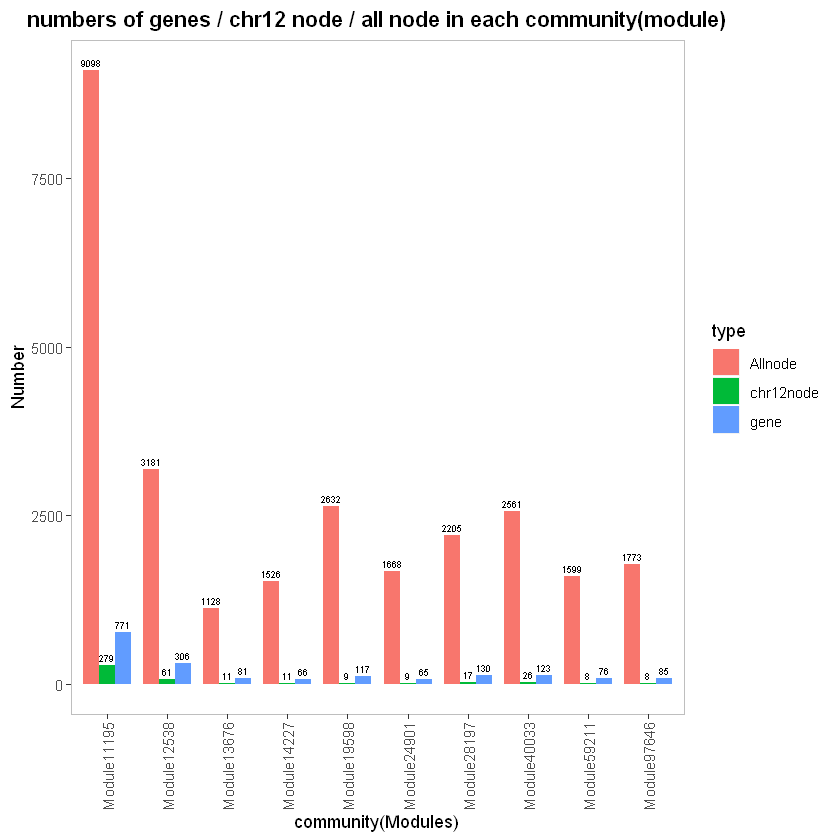

In [54]:
number_gene = module_chr12_list[,c('community','Size_of_chr12genes')][1:10,]
number_gene$type = rep('gene', nrow(number_gene))
names(number_gene)[2] = 'count' 

number_chr12node = module_chr12_list[,c('community','size_of_chr12Node')][1:10,]
number_chr12node$type = rep('chr12node', nrow(number_chr12node))
names(number_chr12node)[2] = 'count'

number_AllNode = module_chr12_list[,c('community','size_of_allNode')][1:10,]
number_AllNode$type = rep('Allnode', nrow(number_AllNode))
names(number_AllNode)[2] = 'count'

number_gene_chr12node_AllNode = rbind(number_gene,number_chr12node,number_AllNode)

library(ggplot2)
ggplot(number_gene_chr12node_AllNode, aes(x = community, y = count,fill = type)) +
  geom_bar(stat="identity", position = 'dodge',width=0.8)+  ##identity意味着把y当做值去输入，如果改成bin，就会计算y出现的频数。dodge意味是各组是左右分布而不是上下重叠
  labs(x="community(Modules)",y = "Number")+
  ggtitle("numbers of genes / chr12 node / all node in each community(module)", ) + backgroup+
  geom_text(aes(x = number_gene_chr12node_AllNode$community, 
                y = number_gene_chr12node_AllNode$count,
                group = number_gene_chr12node_AllNode$type, 
                label=number_gene_chr12node_AllNode$count), position=position_dodge(0.8),hjust=0.5, size = 2, vjust = -0.5)

<h2 id='6.3'> enriched modules in some KEGG pathway or GO term.</h2>

We use `module_chr12_list` to enrich GO and KEGG.

<h3 id='6.3.1'> Enrich GO </h3>

In [52]:
library(clusterProfiler)
module_chr12_list_enrichGO <- list()
for (i in 1:nrow(module_chr12_list)){
  module_gene <- unlist(module_chr12_list$genelist[i])
  module_chr12_list_enrichGO[i] <- enrichGO(module_gene, 
                                            'org.Hs.eg.db',
                                            keyType = 'SYMBOL', 
                                            pvalueCutoff = 0.05)
}
names(module_chr12_list_enrichGO) <- module_chr12_list$community


Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE
clusterProfiler v3.12.0  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.
Loading required package: org.Hs.eg.db
Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xta

"implicit list embedding of S4 objects is deprecated"Warning message in `[<-`(`*tmp*`, i, value = enrichGO(module_gene, "org.Hs.eg.db", :
"implicit list embedding of S4 objects is deprecated"Warning message in `[<-`(`*tmp*`, i, value = enrichGO(module_gene, "org.Hs.eg.db", :
"implicit list embedding of S4 objects is deprecated"

In [53]:
head(module_chr12_list_enrichGO[[1]]@result)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0008527,GO:0008527,taste receptor activity,11/200,24/16969,1.009813e-15,2.820017e-13,2.574398e-13,TAS2R7/TAS2R8/TAS2R9/TAS2R10/TAS2R13/TAS2R14/TAS2R50/TAS2R31/TAS2R46/TAS2R43/TAS2R30,11
GO:0033038,GO:0033038,bitter taste receptor activity,10/200,18/16969,1.663727e-15,2.820017e-13,2.574398e-13,TAS2R7/TAS2R8/TAS2R10/TAS2R13/TAS2R14/TAS2R50/TAS2R31/TAS2R46/TAS2R43/TAS2R30,10
GO:1901618,GO:1901618,organic hydroxy compound transmembrane transporter activity,6/200,36/16969,3.607791e-06,4.076804e-04,3.721721e-04,SLCO1B3/SLCO1B1/SLCO1A2/SLC2A13/SLC16A7/SLC5A8,6
GO:0030246,GO:0030246,carbohydrate binding,13/200,252/16969,9.466928e-06,7.888367e-04,7.201304e-04,CLEC4C/CLEC6A/CLEC4D/CLEC4E/KLRG1/KLRB1/KLRF1/CLEC2B/KLRF2/CLEC2A/CLEC12A/CLEC1B/CNTN1,13
GO:0008028,GO:0008028,monocarboxylic acid transmembrane transporter activity,5/200,26/16969,1.163476e-05,7.888367e-04,7.201304e-04,SLCO1B3/SLCO1B1/SLCO1A2/SLC16A7/SLC5A8,5
GO:0005546,GO:0005546,"phosphatidylinositol-4,5-bisphosphate binding",6/200,65/16969,1.152138e-04,6.509580e-03,5.942606e-03,PLCZ1/SYT10/TWF1/SYT1/RPH3A/RAB35,6


<h3 id='6.3.2'> Enrich KEGG</h3>

In [55]:
#-------------------------------

module_chr12_list_enrichKEGG <- list()
library(org.Hs.eg.db)
library(clusterProfiler)
for (i in 1:nrow(module_chr12_list)){
module_gene <- unlist(module_chr12_list$genelist[i])
geneIDselect <-select(org.Hs.eg.db, #.db是这个芯片数据对应的注释包
                      keys= module_gene,
                      columns=c("ENTREZID","ENSEMBL","GENENAME"), #clolumns参数是你要转换的ID类型是什么，这里选择三个。
                      keytype="SYMBOL" )#函数里面的keytype与keys参数是对应的，keys是你输入的那些数据，keytype是指这些数据是属于什么类型的数据。 
module_chr12_list_enrichKEGG[i] = enrichKEGG(geneIDselect$ENTREZID, organism = 'hsa', keyType = "kegg", pvalueCutoff = 0.05)
}
names(module_chr12_list_enrichKEGG) <- module_chr12_list$community
#--------------------------------------------------------------

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows'select()' returned 1:many mapping between keys and columns
Warning message in `[<-`(`*tmp*`, i, value = enrichKEGG(geneIDselect$ENTREZID, organism = "hsa", :
"implicit list embedding of S4 objects is deprecated"'select()' returned 1:many mapping between keys and columns
Warning message in `[<-`(`*tmp*`, i, value = enrichKEGG(geneIDselect$ENTREZID, organism = "hsa", :
"implicit list embedding of S4 objects is deprecated"'select()' returned 1:1 mapping between keys and columns
Warning message in `[<-`(`*tmp*`, i, value = enrichKEGG(geneIDselect$ENTREZID, organism = "hsa", :
"implicit list embedding of S4 objects is deprecated"'select()' returned 1

"implicit list embedding of S4 objects is deprecated"'select()' returned 1:many mapping between keys and columns
Warning message in `[<-`(`*tmp*`, i, value = enrichKEGG(geneIDselect$ENTREZID, organism = "hsa", :
"implicit list embedding of S4 objects is deprecated"'select()' returned 1:1 mapping between keys and columns
Warning message in `[<-`(`*tmp*`, i, value = enrichKEGG(geneIDselect$ENTREZID, organism = "hsa", :
"implicit list embedding of S4 objects is deprecated"'select()' returned 1:1 mapping between keys and columns
Warning message in `[<-`(`*tmp*`, i, value = enrichKEGG(geneIDselect$ENTREZID, organism = "hsa", :
"implicit list embedding of S4 objects is deprecated"'select()' returned 1:1 mapping between keys and columns
Warning message in `[<-`(`*tmp*`, i, value = enrichKEGG(geneIDselect$ENTREZID, organism = "hsa", :
"implicit list embedding of S4 objects is deprecated"'select()' returned 1:1 mapping between keys and columns
Warning message in `[<-`(`*tmp*`, i, value = enrich

In [56]:
head(module_chr12_list_enrichKEGG[[1]]@result)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa04742,hsa04742,Taste transduction,14/96,83/7926,7.378272e-13,1.128876e-10,1.128876e-10,50837/50836/50835/50839/50838/50840/259296/259295/259294/259290/259292/259289/259293/353164,14
hsa04970,hsa04970,Salivary secretion,6/96,90/7926,7.407767e-04,4.735242e-02,4.735242e-02,5554/5555/5542/653247/4069/4842,6
hsa04740,hsa04740,Olfactory transduction,14/96,448/7926,9.284788e-04,4.735242e-02,4.735242e-02,441639/121364/254783/283365/390321/254786/390323/403282/390326/341416/390327/403284/341418/121129,14
hsa04976,hsa04976,Bile secretion,4/96,72/7926,1.109808e-02,4.245017e-01,4.245017e-01,28234/338821/10599/6579,4
hsa05205,hsa05205,Proteoglycans in cancer,6/96,204/7926,3.700216e-02,9.460111e-01,9.460111e-01,79923/10818/4060/1634/3479/11211,6
hsa04625,hsa04625,C-type lectin receptor signaling pathway,4/96,104/7926,3.709847e-02,9.460111e-01,9.460111e-01,93978/338339/26253/51266,4


<h1 id='7'>7. Get All genes names</h1>

Create a function to get all genes names in neo4j.

As we know, GREG only `Details` property have gene names informations in each chromosome nodes.

So, the first step, we get all nodes which had `Details` property.  
Second, we use `split` to split the `Details` information, at this step, we get a list of `Details` information.  
Thrid, we use command `UNWIND` to change the list format.  
Forth, we use `contains` to filter those `Details` information which includes `gene_name`. 
At the end, we use `substring` to get real gene names.

In [57]:
#----------------------------------------------------------------------
#---建一个函数来获取数据库里面所有gene names
#该基因gene name 存在于 node的Details属性上
#返回数据框，包含基因名称，节点的id号和节点label， 节点Name

getAllGeneName = function(){
  #连接neo4j数据库
  
  library(RNeo4j)
  graph = startGraph("http://localhost:7474/db/data/", username="neo4j", password="xiaowei")
  
  #cypher语言查询
  query = "
        //get all nodes which had `Details` property
        //查找有Details属性的节点
      MATCH (n)
      where exists(n.Details)

        //split the Details information
        //利用split函数拆分Details属性值
      with split(n.Details, ';') AS Details,id(n) AS NodeID, labels(n) AS NodeLabel, n.Name AS NodeNames

        //change the list format
        //利用UNWIND将Details列表换成表格形式
      UNWIND Details AS details
      with details, NodeID, NodeLabel, NodeNames

        //filter those Details information which includes gene_name
        // 筛选出含有gene_name的信息
      where details contains 'gene_name'
      with details as genes, NodeID, NodeLabel, NodeNames

        // use `substring` to get real gene names
        // 然后利用substring函数截取基因名称， 返回基因名称，节点的id号和节点label
      return substring(genes,11) as geneName, NodeID, NodeLabel, NodeNames
  "
  #进行查询
  allGenes <- RNeo4j::cypher(graph, query) 
  
  #返回查询结果
  return(allGenes)
}

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

In [58]:
AllgeneName <- getAllGeneName()
head(AllgeneName )

geneName,NodeID,NodeLabel,NodeNames
<chr>,<int>,<chr>,<chr>
DDX11L1,0,chr1,Bin1
WASH7P,0,chr1,Bin1
MIR6859-1,0,chr1,Bin1
RP11-34P13.3,0,chr1,Bin1
MIR1302-2,0,chr1,Bin1
FAM138A,0,chr1,Bin1


In [59]:
dim(AllgeneName)

[1] 67418     4

<h1 id='8'>  Find the modules that contain the gene "NANOG" and report all the nodes and relationships inside such modules. Also, report if they are enriched in some KEGG pathway or GO term. </h1>

<h2 id='8.1'> Step1： Find out those nodes about target genes</h2>
Find out those nodes contains the gene `"NOANOG"` strings, 

result is a data.frame including `GeneName`, `NodeID`, `NodeLabel` and `NodeNames`.

In [60]:
#接下来我们来尝试一下这一步
#Find the modules that contain the gene "NANOG" 
#and report all the nodes and relationships inside such modules

#首先，我们来得到哪些基因里面包含`NANOG` 的节点信息
#This is for those gene names contain 'NANOG' strings.
#TargetNodes1 <- AllgeneName[grep('NANOG',AllgeneName$geneName, fixed = FALSE), ]

#Find out node id of `NANOG` as gene name 
TargetNodes1 <- AllgeneName[which(AllgeneName$geneName == 'NANOG'), ]

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

In [61]:
TargetNodes1

,geneName,NodeID,NodeLabel,NodeNames
,<chr>,<int>,<chr>,<chr>
39711,NANOG,9759,chr12,Bin39


<h2 id='8.2'> Step2: To get modules which includes target genes</h2>

we use `{}` to input arguments to cypher commands. But at here we need to use cypher command `MATCH (n)   where id(n) in {TargetNodes_NodeID}  with id(n) AS TargetNodes_ID` to get `TargetNodeID` again, then we can follow to match those modules including `TagetNodeID`.

For now, we can not find out what's problems at this step if we directly use  `{}` as match arguments in command `where {TargetNodes_ID} in nodeId`.

Because sometimes we only one gene as targetNode,we should add `if` as conditions to make query comands efective.

In [62]:
#第二步，我们利用{}来传递TargetNode的ID号，并找出含有这些TargetNode的模块


queryLouvainForChr12_TargetNodesInModules =function(TargetNodes){
  query = paste("
        // to make louvain modules for chr12
        CALL algo.louvain.stream(
          'MATCH (n:chr12)--(m) with id(n) as chr12,id(m) AS m   MATCH (al) where id(al) = m or  id(al) = chr12 return id(al) as id',
          'MATCH (n:chr12)-[r]-(m) RETURN id(n) AS source, id(m) AS target',
          {graph:'cypher',direction: 'both'})
        YIELD nodeId, community
        with nodeId, community

        // to get node names
        match(n)
        where id(n) = nodeId
        with collect(nodeId) AS nodeId, community, collect(n.Name) AS AllnodeName 
        
        // filtering community which the number of nodes is more than one
        where size(nodeId) > 1
        with nodeId, 'Module'+ community AS community,AllnodeName

        // filtering community that had target nodes
        MATCH (n)",
                
                
                if (length(TargetNodes) != 1){"where id(n) in {TargetNodes_NodeID}" }
                else{"where id(n) = {TargetNodes_NodeID}"},
                
                "with id(n) AS TargetNodes_ID, n.Name AS TargetNodes_Name, nodeId, community,AllnodeName
        where TargetNodes_ID in nodeId
        return nodeId, community,collect(TargetNodes_ID) AS TargetNodes_ID ,collect(TargetNodes_Name) AS TargetNodes_Name, AllnodeName
        "
                ,sep = ' ')
  return(query)
}

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

In [63]:
query = queryLouvainForChr12_TargetNodesInModules(TargetNodes1$NodeID)
chr12Mod <- cypher(graph, query,TargetNodes_NodeID = TargetNodes1$NodeID)

The result is a data.frame including all nodes ids in each community, community, TargetNodes_ID ,TargetNodes_Name and allnodeName.

In [64]:
names(chr12Mod)

[1] "nodeId"           "community"        "TargetNodes_ID"   "TargetNodes_Name"
[5] "AllnodeName"

In [65]:
#chr12Mod[1,]

<h2 id='8.3'> Step3: build a function to get relationships during nodes in each community(module)</h2>
We build a function to get relationships during nodes in each community(module). The input argument is the result we got at the step2. Results includes two nodes' id, labels, properties and relationship id, type, and properties.

In [66]:
#----------------建一个函数来获取每一个模块节点之间的关系--------------------------------------
#
#The argument is result we get  from step2
#module就是我们前面获取的结果
Module_Relationship = function(Module){
  
    #Module_Relationship as an object for save our results
    #Module_Relationship作为list来存储数据
  Module_Relationship = list()
    
    #To get relationships during nodes in the same modules
    #获取节点之间的关系，返回的结果尽量不要去改变。
    #The results include nodes' id ,label and properties, and relationships' type, id and properties.
    #返回的结果包括节点的id号，label，还有就是节点的属性；以及关系的id号和关系的类型、关系的属性
  for( i in 1:nrow(Module) ){
      #for the vector about all nodes id in the same modules
    Module_NodeID = unlist(Module[[1]][[i]])
    query = "
            // the first we should get all node in the same modules, result is a list
            MATCH (n)
            where id(n) in {Module_NodeID}
            with collect( id(n) ) AS Module_Node_ID
        
        // get relationships 
        MATCH (A)-[r]->(B)
        where id(A) in Module_Node_ID and id(B) in Module_Node_ID
        
        //at here, properties() function for all properties at an node or a relationship    
        RETURN id(A) AS fromNodeID, 
              labels(A) AS fromNodeLabel, 
              
              id(B) AS toNodeID,
              labels(B) AS toNodeLabel,
              
              id(r) AS Relationship_ID,
              type(r) AS Relationship,
          
              properties(A) AS AProperties,
              properties(B) AS BProperties,
              properties(r) AS RProperties
        "
     #run the query for results   
    #Module_Relationship[[i]]= cypher(graph, query, Module_NodeID = Module_NodeID )
    ABRelationship= cypher(graph, query, Module_NodeID = Module_NodeID )
    
    #Now, we split all properties of nodes using unnest_nodes() function in {neo4r}
      #这里解析属性使用的neo4r的unnest_nodes()来拆分
    #解析节点A的属性
    Ap = ABRelationship["AProperties"]
    names(Ap)[1] = "properties"
    App =  neo4r::unnest_nodes(Ap, what = "properties")
    names(App) = paste0("fromNode_", names(App) )
    
    #解析节点B的属性
    Bp = ABRelationship["BProperties"]
    names(Bp)[1] = "properties"
    Bpp =  neo4r::unnest_nodes(Bp, what = "properties")
    names(Bpp) = paste0("toNode_", names(Bpp) )
    
    
    #split properties of relationships,we need make the same formats. If not, there show some wrong and we can not fixed.
    #解析关系的属性
    #这里需要说明的是数据框的列名称和列的位置不能发生变化，否则容易出错，在解析完关系后我们将它的列名还原过来
    Rp = ABRelationship[,c("Relationship_ID","Relationship","fromNodeID","toNodeID","RProperties")]
    names(Rp) = c("id", "type", "stratNode", "endNode", "properties")
    Rpp =  neo4r::unnest_relationships(Rp)
    names(Rpp)[1:4] = c("Relationship_ID","Relationship","fromNodeID","toNodeID")
    names(Rpp)[c(-(1:4))] = paste0("R_", names(Rpp)[c(-(1:4))] )
    
    #union all data
    #最后，合并每一列
    alldataRelationship = cbind(Rpp,App,Bpp, ABRelationship[,c("fromNodeLabel","toNodeLabel")])
    ColNames = c("fromNodeID","fromNodeLabel","toNodeID","toNodeLabel","Relationship_ID","Relationship",
                 names(App),
                 names(Bpp),
                 names(Rpp)[c(-(1:4))])
    Module_Relationship[[i]] = alldataRelationship[,ColNames]
  }
  
  names(Module_Relationship) = Module$community
  
  return(Module_Relationship)
}


Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

<h2 id='8.4'> step4: get relationships during nodes in each community(module)</h2>
Now, we get relationships during nodes in each community(module), result is a list including data.frame data that have nodeID and their relationship.

In [67]:
#---------获取Module里的node的关系-------------------------------------------------------------
Module_Relationships <- Module_Relationship(chr12Mod)

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windowsWarning message:
"The `.drop` argument of `unnest()` is deprecated as of tidyr 1.0.0.
All list-columns are now preserved.
This warning is displayed once per session.
Call `lifecycle::last_warnings()` to see where this warning was generated."

Let's us see what we get.**It includes all properties about nodes and relationships.**

In [68]:
head(Module_Relationships[[1]])

fromNodeID,fromNodeLabel,toNodeID,toNodeLabel,Relationship_ID,Relationship,fromNode_Start,fromNode_End,fromNode_community,fromNode_Details,...,R_PubMedID,R_CellType,R_SourceDB,R_Method,R_value,R_GEO,R_Start,R_OtherGEO,R_End,R_Information
<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>
1260758,chr12_Range,1260608,chr12_Range,5445098,Interaction,3364835,3366835,11194,NA,...,24821768,IPS6.9,CistromeDB,IM-PET,NA,NA,NA,NA,NA,NA
1260419,chr12_Range,1260608,chr12_Range,5387397,Interaction,3365035,3367035,11194,NA,...,24821768,IPS19.11,CistromeDB,IM-PET,NA,NA,NA,NA,NA,NA
846310,chr12_Range,862700,chr12_Range,4781208,Interaction,3217835,3219835,11194,NA,...,24821768,IMR90,CistromeDB,IM-PET,NA,NA,NA,NA,NA,NA
828244,chr12_Range,828221,chr12_Range,4752100,Interaction,3387216,3396473,11194,NA,...,24141950,IMR90,CistromeDB,Hi-C,NA,NA,NA,NA,NA,NA
828244,chr12_Range,828197,chr12_Range,4752099,Interaction,3387216,3396473,11194,NA,...,24141950,IMR90,CistromeDB,Hi-C,NA,NA,NA,NA,NA,NA
828230,chr12_Range,828197,chr12_Range,4752080,Interaction,3357413,3361741,11194,NA,...,24141950,IMR90,CistromeDB,Hi-C,NA,NA,NA,NA,NA,NA


<h1 id='9'>Select the modules that include NANOG AND CTCF AND EP300 AND POLR2A AND YY1 AND cohesin (RAD21, SMC3, OR STAG1) AND mediator (MED1 or MED12).</h1>

<h2 id='9.1'> Step1: Get nodes in all gene names in chromosomes,TF and LncRNA.</h2>
For this term, its include TF genes, so we expand nodes of TF and LncRNA labels as following codes:


In [69]:
#-----------TF----------------------
query = "MATCH (n:TF)
        RETURN n.Name AS geneName, id(n) AS NodeID, labels(n) AS NodeLabel, n.Name AS NodeNames"
TFName = cypher(graph, query)
#-----------LncRNA----------------
query = "MATCH (n:LncRNA)
        RETURN n.Name AS geneName, id(n) AS NodeID, labels(n) AS NodeLabel, n.Name AS NodeNames"
LncRNAName = cypher(graph, query)
#------------AllgeneName_TF_LncRNA--------------------------------------
AllgeneName_TF_LncRNA = rbind(TFName, LncRNAName, AllgeneName)

So `AllgeneName_TF_LncRNA` includes all genes in all chromosomes, all transcription factors(TFs) and all LncRNA in GREG.

In [70]:
head(AllgeneName_TF_LncRNA)

geneName,NodeID,NodeLabel,NodeNames
<chr>,<int>,<chr>,<chr>
AFF4,15448,TF,AFF4
AHR,15449,TF,AHR
ARID3A,15450,TF,ARID3A
ARNT,15451,TF,ARNT
ARRB1,15452,TF,ARRB1
ATF1,15453,TF,ATF1


In [71]:
dim(AllgeneName_TF_LncRNA)

[1] 67714     4

##### There has 67714 genes, TFs and LncRNA in GREG.

<h2 id='9.2'> Step2: A vector about out genes.</h2>

In [72]:
#----------Find the gene nodes------------------------------------
gene <- c('NANOG', 'CTCF', 'EP300', 'POLR2A', 'YY1', 'RAD21', 'SMC3', 'STAG1', 'MED1', 'MED12')

<h2 id='9.3'> Step3: Create a function `geneMatchIndex` for find out those nodes that genes we want.</h2>

Here we create a function for match those genes by full match or fuzzy match. Full match means your input is full name of genes, that you only get this nodes that gene names is your input.  

`allGeneNode` is you chose which one as your match, It must one of `AllgeneName_TF_LncRNA`, `TFName` , `LncRNAName` and `AllgeneName`

This is as defaults. please set argument `FullMatch = 0` If you want use fuzzy match for those gene names contain strings of your input. 

The argument `by` must one of `"geneName"`,  `"NodeID"` ,   `"NodeLabel"` and `"NodeNames"`. It means the type of your input data.

Result is a list includes a data frame of `TargetNodes` about genes and a vector `NoGeneIndex` about those genes not in GREG. 


In [73]:
#-----------grep或者which---------------------
#-----------------------------------------
#a function geneMatchIndex for find out those nodes that genes we want
#一个函数用来查找gene在所有基因数据框内的对应位置和没有匹配的基因

# allGeneNode is you chose which one as your match. It must is one of AllgeneName_TF_LncRNA, TFName, LncRNAName and AllgeneName.

#This is as defaults. please set argument `FullMatch = 0` If you want use fuzzy match for those gene names contain strings of your input.
#FullMatch默认为1，也就是说默认使用的是完全匹配的方式，找到的基因名称跟输入的是一模一样的
#FullMatch如果是其他数字，则用grep的方式查找含有该字符串的基因位置

#Result is a list includes a data frame of `TargetNodes` about genes and a vector `NoGeneIndex` about those genes not in GREG.
#返回的是两个向量的list，geneIndex是对应基因的位置；NoGeneIndex是该基因在数据库中没有找到

#The argument `by` must one of `"geneName"`,  `"NodeID"` ,   `"NodeLabel"` and `"NodeNames"`. It means the type of your input data.
#第三个参数是指匹配的是哪个类型， 是属于基因名，还是节点id，节点的label和节点名称
#第三个参数 即 "geneName"  "NodeID"    "NodeLabel" "NodeNames"

geneMatchIndex = function(gene, allGeneNode, FullMatch = 1, by = "geneName"){
  geneIndex = c() 
  NoGeneIndex =  c()
  Ag = allGeneNode[by]
  if (FullMatch == 1){
    #----------which-----------------
    for (i in 1:length(gene) ) {
      geneIndex1 = which(Ag == gene[i] )
      if (length(geneIndex1) == 0){NoGeneIndex = c(gene[i], NoGeneIndex)}
      else{geneIndex = c(geneIndex,geneIndex1)}
    }
  }
  
  else{
    #----------grep---------------
    for (i in 1:length(gene) ) {
      geneIndex1 = grep(gene[i],Ag, fixed = TRUE)
      if (length(geneIndex1) == 0){NoGeneIndex = c(gene[i], NoGeneIndex)}
      else{geneIndex = c(geneIndex,geneIndex1)}
    }
  }
  
  TargetNodes <- allGeneNode[geneIndex, ]
  geneInGREG = list(TargetNodes, NoGeneIndex)
  names(geneInGREG) = c("TargetNodes", "NoGeneIndex")
  #返回匹配上的TargetNodes和没有找到基因NoGeneIndex
  return (geneInGREG )
}


Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

<h2 id='9.4'> Step4: Find out those nodes that genes we want.</h2>

DNA annotation == NANOG AND [TF == CTCF AND EP300 AND POLR2A AND YY1 AND (RAD21 OR SMC3 OR STAG1) AND (MED1 OR MED12)]

In [74]:
#------------------------------------ 
geneIndex1 = geneMatchIndex('NANOG',AllgeneName)
geneIndex2 = geneMatchIndex(gene[-1],TFName)
TargetNodes2 <- rbind(geneIndex1$TargetNodes,geneIndex2$TargetNodes)
TargetNodes2 

,geneName,NodeID,NodeLabel,NodeNames
,<chr>,<int>,<chr>,<chr>
39711,NANOG,9759,chr12,Bin39
40,CTCF,15487,TF,CTCF
58,EP300,15505,TF,EP300
155,POLR2A,15602,TF,POLR2A
240,YY1,15687,TF,YY1
167,RAD21,15614,TF,RAD21
194,SMC3,15641,TF,SMC3
205,STAG1,15652,TF,STAG1
125,MED1,15572,TF,MED1


<h2 id='9.5'> Step5: To get modules which includes target genes</h2>

At here, we use the query command at part`8.2` for modules nodes.

In [75]:
#---------------------------
#找到包含了这些基因节点的模块
query = queryLouvainForChr12_TargetNodesInModules(TargetNodes2$NodeID)
TargetNodesInModules <- cypher(graph, query, TargetNodes_NodeID = TargetNodes2$NodeID)

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

In [76]:
length(TargetNodesInModules)

[1] 5

In [77]:
TargetNodesInModules$TargetNodes_Name

[[1]]
[[1]][[1]]
[1] "Bin39"

[[1]][[2]]
[1] "CTCF"

[[1]][[3]]
[1] "EP300"

[[1]][[4]]
[1] "RAD21"

[[1]][[5]]
[1] "SMC3"

[[1]][[6]]
[1] "STAG1"

[[1]][[7]]
[1] "MED1"


[[2]]
[[2]][[1]]
[1] "YY1"


[[3]]
[[3]][[1]]
[1] "POLR2A"


[[4]]
[[4]][[1]]
[1] "MED12"

`TargetNodesInModules` has 5 modules.

<h2 id='9.6'> Step6: Build a function to judge which modules is we want.</h2>

`real_TargetNodes_In_Modules` function use to chose those modules includes nodes/genes as we designs(ask).

argument `TargetNodesInModules` is like the last result.

argument `gene` is a vector which includes all genes we want.

argument `MustIn` is a vertor which includes genes we ask must in this modules.

Argument `OrIn` is a vertor which includes genes some in this modules, and some may not in, but always at least one genes in. 

`OrIn2` is the same of `OrIn`.

In [78]:
#-------------------------------------------------------------------------------------------------------
#real_TargetNodes_In_Modules function use to chose those modules includes nodes/genes as we designs(ask).
#这个real_TargetNodes_In_Modules函数是用来选择那些符合要求的基因模块列表
#argument TargetNodesInModules is the last result
#参数有TargetNodesInModules就是我们上一步得出的结果TargetNodesInModules，结构必须是相同的
#gene is a vector which includes all genes we want.
#参数gene也是之前使用的
# MustIn is a vertor which includes genes we ask must in this modules
#参数MustIn就是我们选择的gene一定要出现在模块中
#OrIn is a vertor which includes genes some in this modules, and some may not in, but always at least one genes in 
#参数OrIn就是我们选择的gene中至少有一个要出现在模块中
#OrIn2 is the sames of OrIn
#参数OrIn2也就是我们选择的gene中至少有一个要出现在模块中
real_TargetNodes_In_Modules <- function(TargetNodesInModules,gene,MustIn,OrIn = NULL,OrIn2 = NULL){
    index = c()
    eneNotInModule = list()
    for (i in 1:nrow(TargetNodesInModules)){
        #At first, we need to match those genes names about nodes in modules
        #找对节点id号对应的基因名称
        Mod_TargetNodes = unlist(TargetNodesInModules$TargetNodes_ID[i])
        Mod_TargetNodes = geneMatchIndex(Mod_TargetNodes, AllgeneName_TF_LncRNA, by = "NodeID")
        
        #find out genes those are not in this module
        #找到在对应的模块里面不存在的输入的基因
        diff = setdiff(gene, Mod_TargetNodes$TargetNodes$geneName)
        
        #To judge whather module is we want 
        #判断diff是属于哪些基因的，是属于必需的，还是属于可选的，还是不要的
          #-----------------------
          #get an intersection between diff and MustIn, if geneIn was not null, then it judge that this module not as we want 
          #diff和MustIn的交集geneIn，如果有，则那这个模块不能用
          geneIn = intersect(diff,MustIn)
          #即如果geneIn的数量大于0， 则说明diff中有基因是跟MustIn相同的,则那这个模块不能用
          case1 <- length(geneIn) > 0 
          #-----------------------
           #get an intersection between diff and OrIn, if geneOrIn have the same number of OrIn, we can not chose the modules
          if (length(OrIn) > 1 ) {
            #如果diff和OrIn的交集geneOrIn跟OrIn一样多，则说明OrIn中的基因都是diff，那这个模块不能用
            geneOrIn = intersect(OrIn,diff)
            #如果diff和OrIn的交集geneOrIn跟OrIn一样多，则说明OrIn中的基因都是diff，那这个模块不能用
            case2 <- length(geneOrIn) == length(OrIn) }
          else{ case2 = FALSE }
          #-----------------------
          if (length(OrIn2) > 1 ){
          geneOrIn2 = intersect(diff,OrIn2)
          case3 <- length(geneOrIn2) == length(OrIn2)}
          else{ case2 = FALSE }
        
        #If one of three case is TRUE, the module will not be chose.
          #有一个是TRUE则这个模块就不可以用了，这里是case1或者case2或者case3
          if( case1 | case2 | case3) { 
              index = c(index, i)
          eneNotInModule[[i]] = diff}
    }
    names(eneNotInModule) = TargetNodesInModules$community
    #符合所选情况的模块（即根据自己定义了的基因都在对应的模块中）
    realTargetNodesInModules = TargetNodesInModules[c(-index),]
    
    judgeResults = list(realTargetNodesInModules,eneNotInModule)
    names(judgeResults) = c("realTargetNodesInModules","eneNotInModule")
    return(judgeResults)
}
#---------------------------------------------------------------------------------------------------------

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

<h2 id='9.7'> Step7: Select those mudules as we want</h2>

In [79]:


#查看是否都包含这些基因

#现将gene拆分成哪些基因是必需的，哪些是可选的，哪些是不要的
#一定要有的基因
#Genes must is in modules
MustIn = c("NANOG","CTCF", "EP300","POLR2A","YY1")

#Genes may not in modules, but at least one gene in modules
#不一定要有的基因，即可以有，也可以没有，至少有一个在
OrIn = c("RAD21","SMC3","STAG1")
OrIn2 = c("MED1","MED12")

#Select module like we want
judgeResults = real_TargetNodes_In_Modules(TargetNodesInModules,
                                                       gene,MustIn,OrIn,OrIn2)

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

In [80]:
realTargetNodesInModules = judgeResults[[1]]

geneNotInModule = judgeResults[[2]]
#gene <- c('NANOG', 'CTCF', 'EP300', 'POLR2A', 'YY1', 'RAD21', 'SMC3', 'STAG1', 'MED1', 'MED12')
dim(realTargetNodesInModules)

geneNotInModule

[1] 0 5

$Module11193
[1] "POLR2A" "YY1"    "MED12" 

$Module12537
[1] "NANOG"  "CTCF"   "EP300"  "POLR2A" "RAD21"  "SMC3"   "STAG1"  "MED1"  
[9] "MED12" 

$Module17883
[1] "NANOG" "CTCF"  "EP300" "YY1"   "RAD21" "SMC3"  "STAG1" "MED1"  "MED12"

$Module19596
[1] "NANOG"  "CTCF"   "EP300"  "POLR2A" "YY1"    "RAD21"  "SMC3"   "STAG1" 
[9] "MED1"

So, we didn't get an module as we want. 

<h2 id='9.8'> Step8: get relationships during nodes in each community(module)</h2>

###### If there have modules as we want, we can get relationships by function `Module_Relationship`.

In [81]:
#假设有的话，我们继续将这个模块的所有关系都找出来
#realTargetNodesInModules = TargetNodesInModules
#Relationship_realTargetNodesInModules <- Module_Relationship(realTargetNodesInModules)

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

In [82]:
#head(Relationship_realTargetNodesInModules[[1]])

<h1 id='10'> save all results<h1>

To get all results at [here](allResults.Rdata).

In [85]:
save(AllgeneName, AllgeneName_TF_LncRNA,BindRel,BindRel_LncRNA, BindRel_TF,   
     chr_level, chr_RangeRel,  chr12_distribution,  chr12_hubs,   
     chr12_hubs_20,chr12Mod, gene, geneIDselect, geneIndex1,   geneIndex2,  
     geneNotInModule,    InclusionRel, InteractionRel, 
     judgeResults,labels,   LncRNAName,   module_chr12, module_chr12_list,   
     module_chr12_list_enrichGO, module_chr12_list_enrichKEGG , 
     module_chr12_total,  module_gene,   module_genelist, 
     Module_Relationship,  Module_Relationships,  MustIn,  
     number_AllNode,   number_chr12node, number_gene,  number_gene_chr12node_AllNode,
     OrIn, OrIn2,  real_TargetNodes_In_Modules,  rel_details, 
     relationship_Type, relationshipType, RelSUM,  SumCount,TargetNodes1,
     TargetNodes2, TargetNodesInModules, TF_distribution, TF_hubs,  
     TF_hubs_20,   TFInteractionRel, TFInteractionRelSUM, 
     TFName, file = "allResults.Rdata")